In [1]:
import os
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras import layers
from tensorflow.keras import models

2022-12-17 18:01:35.269653: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-17 18:01:35.512500: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-17 18:01:35.512574: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-17 18:01:36.843173: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directo

In [2]:
train_ds, test_ds , val_ds= tfds.load('eurosat/rgb', split=['train[:60%]', 'train[60%:80%]', 'train[80%:]'], shuffle_files=False, as_supervised=True)

2022-12-17 18:01:40.598745: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-17 18:01:40.598807: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-17 18:01:40.598837: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (codespaces-488978): /proc/driver/nvidia/version does not exist
2022-12-17 18:01:40.599239: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
labels = []
for _, label in train_ds:
    labels.append(label.numpy())
labels = np.unique(labels)

In [4]:
BUFFER_SIZE = 1000
BATCH_SIZE = 32
img_height=64
img_width =64
IMG_SIZE = (img_height, img_width)
def resize_image(images, labels):
    images = tf.image.resize(images, IMG_SIZE)
    return images, labels

In [5]:
train_ds = train_ds.map(resize_image).batch(BATCH_SIZE)\
    .prefetch(buffer_size=tf.data.AUTOTUNE)

val_ds = val_ds.map(resize_image).batch(BATCH_SIZE)\
    .prefetch(buffer_size=tf.data.AUTOTUNE)

test_ds = test_ds.map(resize_image).batch(BATCH_SIZE)\
    .prefetch(buffer_size=tf.data.AUTOTUNE)

In [6]:
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(input_shape=(img_height, img_width, 3),
                        include_top=False,
                        weights='imagenet')

base_model.trainable = False

tf.keras.utils.set_random_seed(42)

model_resnet = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(10)
])

# Compile the model
model_resnet.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

In [7]:
history = model_resnet.fit(train_ds, validation_data=val_ds, epochs=5)

Epoch 1/5
507/507 [==============================] - 102s 192ms/step - loss: 0.4645 - accuracy: 0.8535 - val_loss: 0.2979 - val_accuracy: 0.9100
Epoch 2/5
507/507 [==============================] - 74s 146ms/step - loss: 0.2183 - accuracy: 0.9301 - val_loss: 0.2668 - val_accuracy: 0.9183
Epoch 3/5
507/507 [==============================] - 110s 217ms/step - loss: 0.1560 - accuracy: 0.9506 - val_loss: 0.2586 - val_accuracy: 0.9211
Epoch 4/5
507/507 [==============================] - 125s 246ms/step - loss: 0.1198 - accuracy: 0.9635 - val_loss: 0.2658 - val_accuracy: 0.9222
Epoch 5/5
507/507 [==============================] - 60s 119ms/step - loss: 0.0947 - accuracy: 0.9709 - val_loss: 0.2783 - val_accuracy: 0.9213


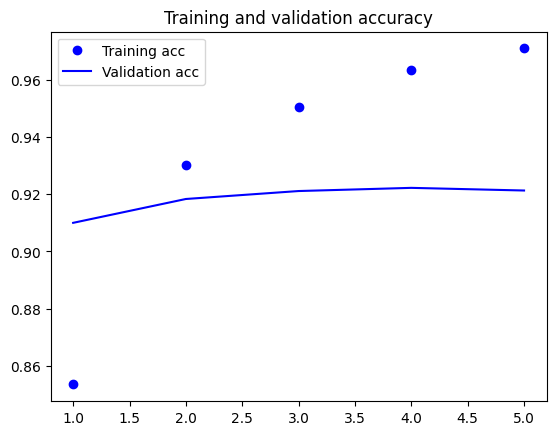

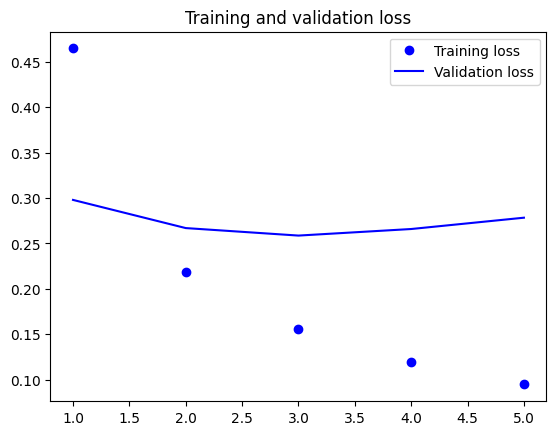

In [8]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

169/169 [==============================] - 18s 97ms/step


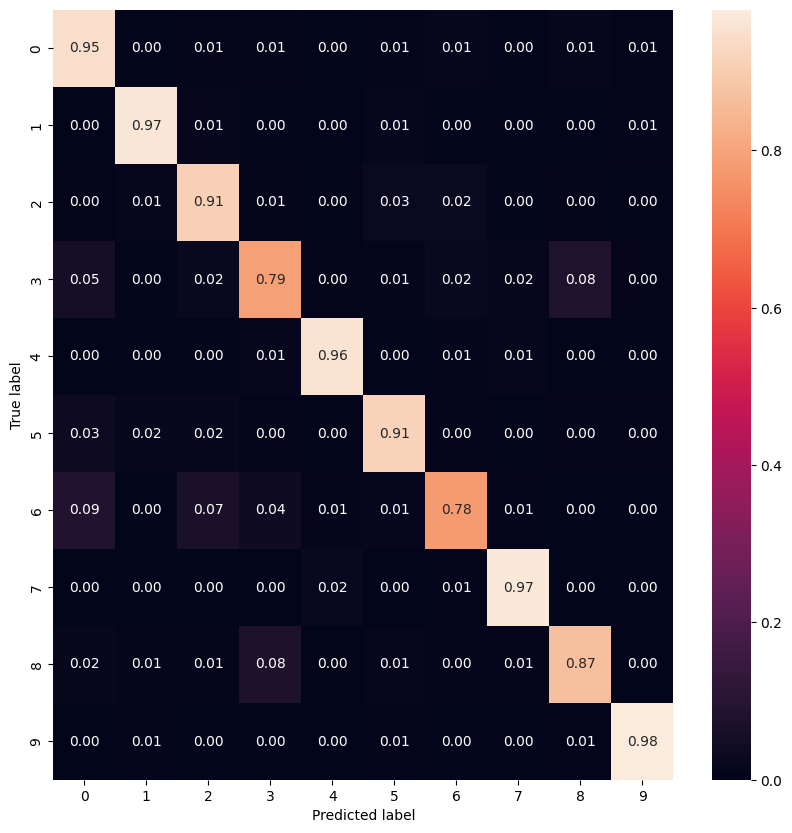

In [9]:
# Show the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model_resnet.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
y_true = []
for _, label in test_ds:
    y_true.append(label.numpy())
y_true = np.concatenate(y_true)

cm = confusion_matrix(y_true, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [10]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.95      0.90       598
           1       0.96      0.97      0.96       593
           2       0.89      0.91      0.90       611
           3       0.83      0.79      0.81       461
           4       0.96      0.96      0.96       504
           5       0.89      0.91      0.90       446
           6       0.90      0.78      0.84       524
           7       0.96      0.97      0.97       599
           8       0.88      0.87      0.88       493
           9       0.98      0.98      0.98       571

    accuracy                           0.91      5400
   macro avg       0.91      0.91      0.91      5400
weighted avg       0.91      0.91      0.91      5400

